In [1]:
% pylab inline

%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


# Introduction to Gradient Descent

In this lesson we'll learn about gradient descent, a numerical optimization method used in the fitting process of many machine learning models. The goal of gradient descent is to find a point (vector) that approximately minimizes a function without needing to derive an exact, closed-form equation for this point. This is very useful to us because it is *often easier and computationally faster to find a minimum with GD than with exact solutions*. 

In particular, **gradient descent is commonly used for finding linear regression coefficients**. We've seen that we choose these coefficients by minimizing a **cost function**, which means that we can apply gradient descent to find an optimal vector of coefficients. Parameter selection via gradient descent also extends beyond this setting to more advanced methods like neural networks, which we'll cover later in the course.

**Learning Outcomes**: after this lesson, you will:

1. Understand the math and concepts underpinning gradient descent
2. Be able to implement simple GD in code
3. Understand how GD can be used to learn coefficients in a linear regression model

### 1. Tangent Lines and Steepest Descent

We'll start by reviewing concepts from single-variable calculus that we'll soon generalize to multivariate functions. 

Remember that taking the derivative of a function $f$ at a specific point $x$ gives us the **instantaneous rate of change of $f$ at that point**. Geometrically, this rate is the slope of the line tangent to $f$ at that point. The size of the slope gives us the magnitude of change, and the sign of the slope gives us the direction of change. 

In other words, the **slope points in the direction of steepest increase** -- a positive slope indicates that increasing $x$ will increase $f(x)$, while a negative slope indicates that decreasing $x$ will increase $f(x)$. For gradient descent we'll actually be interested in steepest decrease, which we get by simply moving in the direction opposite to steepest increase.

Let's demonstrate this visually - we'll define a function for plotting curves and tangent lines, with an arrow to show the direction of steepest descent.

In [2]:
def plot_tangent_at_pt(f, df_dx, p, x_range):
    """
    Plot a curve and the line tangent to that curve at (p,f(p)),
    with an arrow marking the direction of steepest descent
    
    Parameters:
    -----------
    f: function describing curve to plot
    df_dx: derivative of f with respect to x
    p: x coordinate of tangent line point
    x_range: x axis values to plot, should be symmetric about 0    
    """
    
    # may need to expand plotting range to accomodate p
    if p < x_range[0]:
        x_range = np.linspace(p-2, -p+2, num=100*np.abs(p))
    if p > x_range[-1]:
        x_range = np.linspace(-p-2, p+2, num=100*np.abs(p))
    
    # restrict x_range to plot tangent over
    x_tangent = x_range[(x_range > p-1) & (x_range < p+1)]
    
    # calculate slope and intercept of tangent line
    slope = df_dx(p) 
    intercept = f(p) - slope*p  
    
    plt.figure(figsize=(3,3))
    
    # plot curve
    plt.plot(x_range,f(x_range))
    
    # plot tangent line with direction of steepest descent at (p,f(p))
    direction = '->' if slope > 0 else '<-'   
    plt.annotate('', xy=(x_tangent[0], slope*x_tangent[0] + intercept),
                 xytext=(x_tangent[-1], slope*x_tangent[-1] + intercept),
                 arrowprops={'arrowstyle': direction, 'color': 'orange', 'lw':1.3})
    
    # highlight (p,f(p))
    plt.scatter(p,f(p),c='r')
    
    plt.title('Curve f(x) with tangent line at ({:.2f},{:.2f})'.format(p,f(p)))
    plt.show()

Let's apply our plotting function to a simple parabola:

$$ f(x) = x^2 $$

$$ \frac{df}{dx}(x) = 2x $$

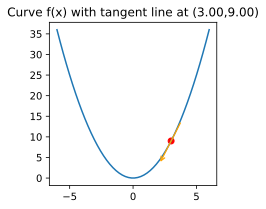

In [3]:
# lambda syntax for quick function definition
f = lambda x: x**2
df_dx = lambda x: 2*x

plot_tangent_at_pt(f, df_dx, 3, np.linspace(-6,6))

**Comprehension Check**: what do you expect to see if I pass the x coordinate -5 to our plotting function?  

**Try it yourself** - spend a bit of time plugging different values in for pt. Notice how the slope of the tangent line changes depending on the point of the curve we're at, following the trajectory of the curve around that point. 

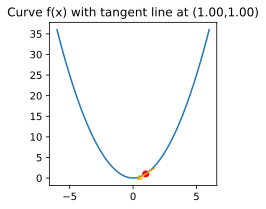

In [4]:
# let's try plugging in different values for pt and rerunning this cell
plot_tangent_at_pt(f, df_dx, 1, np.linspace(-6,6))

### 2. Gradient Descent: First Pass

Now, imagine that we start at a random point on the curve and want to find the minimum. Assume that the only information we have available is the slope of the tangent line at that point (i.e. the derivative). We can't cheat and look at a plot to visually identify the minimum!   

Luckily, it turns out that being able to calculate the derivative at every point is all we need to implement a strategy for eventually finding the minimum. The key fact is that as in section 1, the derivative gives us the **path of steepest descent** at any point. This means that as long as we take a small enough step along that path, we should end up at a lower point on the curve. By repeatedly taking many of these steps, we can gradually approach the minimum and eventually get arbitrarily close to it, no matter where we started.

This strategy gives us the following algorithm, **gradient descent** for a single-variable function:

_ _ _ _ _
**Update Rule**: for each step update the current $x$ coordinate $x_n$ via 

$$x_{n+1} = x_n - \alpha\frac{df}{dx}(x_n)$$, 
where $\alpha$ is a constant called the **learning rate**. 
_ _ _ _ _

It turns out that as long as $f$ is a [convex function](https://en.wikipedia.org/wiki/Convex_function) and the learning rate is small enough, this strategy is guaranteed to converge to the true minimum. In practice, we try to choose $\alpha$ to be small enough that our steps aren't too dramatic, but large enough that the descent does not take an excessive number of steps to reach a strong approximate minimum. 

In the code block below, we implement the update rule and visual the descent. There are a few different stopping criteria we could use, but here we'll choose a very simple one -- stop if $x_{n+1}$ is very close to $x_n$, suggesting that we're close to convergence.    

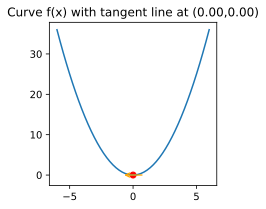

In [5]:
from IPython import display
import time

alpha = .2 # learning rate
tol = .0001 # tolerance level for stopping criterion
x = np.random.uniform(-6,6) # random starting point
        
display.clear_output()
while True:    
    # simple animated plotting
    plot_tangent_at_pt(f, df_dx, x, np.linspace(-6,6))    
    display.clear_output(wait=True)
    time.sleep(1)
    
    # gradient descent update rule
    x_delta = alpha * df_dx(x) 
    x = x - x_delta
    
    # check stopping criterion
    if np.abs(x_delta) < tol:
        break    

Intuitively, gradient descent is just like rolling down a hill. Try running the code block above a few more times to see how we end up finding the minimum no matter where we start. 

_ _ _ _ _
**Exercise** (a few minutes): Try adjusting the *learning rate* alpha and see what happens. How would you explain the result when alpha is greater than 1, from both an intuitive and mathematical perspective?
_ _ _ _ _

### 3. Generalizing Gradient Descent to many Dimensions

Though it becomes impossible to visualize beyond 2-variable functions, multi-dimensional gradient descent is conceptually identical to what we've seen in the 1D case. Actually, this is where the gradient part comes in -- calculated at a point on the surface defined by a function, the **gradient of that function always points in the direction of steepest ascent**. So for steepest descent, we can just move in the direction opposite the gradient.

Remember that for a p-variable function f, the **gradient is a vector-valued function** defined as follows: $$ \nabla f = (\frac{\partial f}{\partial x_1}, ..., \frac{\partial f}{\partial x_p}) $$

I.e., to compute the gradient at a point, we take the partial derivative of f with respect to each variable and compute that partial for each coordinate of the point.

_ _ _ _ _
**Example**: If $f(x,y) = x^2 + 3 - y$, then $\nabla f(x,y) = \frac{\partial }{\partial x}(x^2 + 3 - y), \frac{\partial }{\partial y}(x^2 + 3 - y) = (2x, -1)$. So $\nabla f(3,5) = (6, -1)$.
_ _ _ _ _

Like with simple 1D derivatives, one way to find a (convex) function's minimum is to set the gradient to 0, then solve for all of the variables.

_ _ _ _ _
**Exercise** (few minutes): 
$$f(x, y) = \frac{x^2-8x+7}{3} + \frac{y^2-5x+8}{6}$$

Find the minimum of $f$ using pure calculus: find the *gradient* of $f$, set it to $0$, and solve for $x$ and $y$. 
_ _ _ _ _

This method works nicely for a simple case like 2D functions, but solving the systems of equations can become quite complicated and time consuming in higher dimensions. This is where gradient descent steps in - instead of solving a solving a complex system of equations (computationally expensive), **it's often faster to perform many gradient calculations to approximate the solution with GD**. Let's go ahead and formalize the algorithm: 

_ _ _ _ _
**Update Rule**: where $\mathbf{x_{n}}$ denotes a vector and $\alpha$ again denotes the learning rate, 

$$\mathbf{x_{n+1}} = \mathbf{x_n} - \alpha\nabla f(\mathbf{x_n})$$
_ _ _ _ _

To continue to build our intuition, let's apply this more general rule to the case that we can still visualize: 2-variable functions. To do so, we'll define a function for displaying a 3D plot of the function surface, the point we're at, and the negative gradient vector at that point. Then we'll run the GD process again with the generalized update rule.  

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def plot_gradient_2D_at_pt(f, f_grad, p, xy_range):
    """
    Plot a surface and the direction of steepest descent
    (negative gradient vector) at the point (p,f(p)) on the surface
    
    Parameters:
    -----------
    f: function describing surface to plot
    f_grad: gradient of f
    p: x, y coordinates to calculate gradient at
    xy_range: x and y axis values to plot, should be symmetric about 0    
    """
        
    # compute f(x,y) and gradient
    x, y = p[0], p[1]
    z = f(x, y)
    grad_x, grad_y = f_grad(x, y) 

    # create grids for 3D plotting
    X, Y = np.meshgrid(xy_range, xy_range)
    Z = f(X, Y)

    # create plot with a 3D projection
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # plot surface and highlight p, f(p) on the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=.5)
    ax.scatter(x,y,z,c='r',s=70, marker='*')
    
    # draw line showing negative gradient vector 
    ax.plot([x, x - grad_x], [y, y - grad_y],
            [z, f(x - grad_x, y - grad_y)])

    plt.title('Surface f(x,y) with negative gradient vector at ' 
              '({:.2f},{:.2f},{:.2f})'.format(x,y,z))
    plt.show()

For demonstration, let's use the same function as in the exercise above.

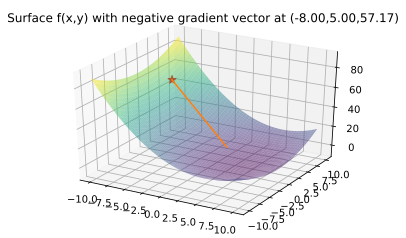

In [7]:
def f(x, y): 
    return (x**2-8*x+7)/3 + (y**2-5*x+8)/6

# check that your math gave you this answer
def f_grad(x, y):
    return (2*x - 8)/3 - 5/6, y/3 

plot_gradient_2D_at_pt(f, f_grad, (-8,5), np.linspace(-10,10,200))

And let's use our gradient descent update rule to find the same minimum that we solved for analytically in the exercise. Our stopping criteria is now based on the euclidean distance between $x_n$ and $x_{n+1}$: i.e. we again stop when the updated point is very close to the previous point.

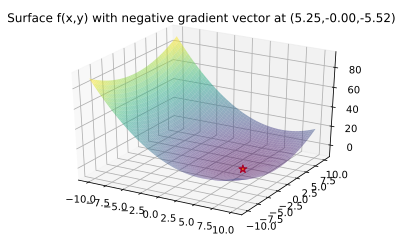

In [8]:
alpha = 1 # learning rate
tol = .001 # tolerance level for stopping criterion
x, y = np.random.uniform(-10,10, size=2) # random starting point
        
display.clear_output()
while True:    
    # simple animated plotting
    plot_gradient_2D_at_pt(f, f_grad, (x,y), np.linspace(-10,10,200))
    display.clear_output(wait=True)
    time.sleep(1)
    
    # gradient descent update rule
    delta = alpha * np.array(f_grad(x,y))
    x, y = x - delta[0], y - delta[1]
    
    # check stopping criterion
    if np.linalg.norm(delta) < tol:
        break  

You can try running the above cell a few times to confirm that wherever we start on the surface, our GD process ends up finding the correct minimum at $(x,y) = (5.25, 0)$. This should be the same answer as in the exercise above.

### 4. Applying Gradient Descent to Linear Regression

As our final learning step, let's tie gradient descent back to machine learning and see why it's such a useful method for us. In particular, we frequently use it to train parametric models like linear regression, where we can **express quality of fit as a function of the model parameters**.

Remember that a linear regression model is given by a linear combination of the features $x_1, ..., x_p$ plus an intercept:

$$ y_{pred} = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p$$

So here, the model parameters are just all of the slope (+ intercept) terms, i.e. the $\beta_j$. For a particular set of training data -- features $X$ target labels $y$ -- **we fit the linear regression by minimizing the following cost function**, a function of the choice of coefficients $\beta_j$: 

$$ J(\beta_0, ..., \beta_p) = \frac{1}{2}\sum_{i=1}^{n} ((\beta_0 + \beta_1 x_1 + ... + \beta_p x_p) - y_i)^2 $$

Intuitively, this is saying that we should choose coefficients such that the resulting predicted values $y_{pred}$ are as close to the real values $y$ as possible.

And here's where gradient descent comes in. The cost function is convex and it's easy to compute the gradient, so **GD provides a recipe for minimizing the cost function, i.e. fitting the linear regression**. 

To find the gradient, in order we can apply the sum rule, the chain rule, and a simple term cancellation (this is why we chose to use the $\frac{1}{2}$ term in the cost function).

$$ \frac{\partial J}{\partial \beta_j} = \frac{1}{2}\sum_{i=1}^{n} \frac{\partial}{\partial \beta_j} ((\beta_0 + \beta_1 x_1 + ... + \beta_p x_p) - y_i)^2 $$

$$ = \frac{1}{2}\sum_{i=1}^{n} 2 ((\beta_0 + \beta_1 x_1 + ... + \beta_p x_p) - y_i) x_i $$

$$ = \sum_{i=1}^{n} ((\beta_0 + \beta_1 x_1 + ... + \beta_p x_p) - y_i) x_i $$

With this gradient in hand, we have everything we need to fit a linear regression model via GD on the coefficients. There's also a closed-form solution to minimizing the cost function, but it requires matrix inversion, which becomes a very computationally expensive task as the number of features scales up. So in practice, gradient descent will typically be used by ML libraries whenever the number of features is medium-large.

This likely feels abstract right now, so let's try to make it more concrete by visualizing the process. Below is code for displaying 2 plots side-by-side: on the left, a scatterplot showing a linear regression model fit; on the right, the cost function surface and our current position. There's a lot of code here! Don't worry too much about trying to understand all of it, just use it for the viz output. 

In [9]:
def cost_function(Beta, x_data, y_data):
    """
    Compute sum of the squared errors cost function J(Beta) for a set
    of observed features and target labels
    
    Parameters:
    -----------
    Beta: choice of coefficient vector
    x_data: 2D array, training data with constant 1st column
    y_data: 1D array, training labels   
    """
    
    return .5 * np.sum((np.matmul(x_data, Beta) - y_data)**2)

def grad_cost_function(Beta, x_data, y_data):
    """
    Compute gradient of SSE cost function J(Beta) for a set
    of observed features and target labels
    
    Parameters:
    -----------
    Beta: choice of coefficient vector
    x_data: 2D array, training data with constant 1st column
    y_data: 1D array, training labels   
    """
    
    Beta = np.array(Beta)
    return np.matmul(np.matmul(x_data, Beta) - y_data, x_data)
    
def viz_reg_fit_and_cost(x_data, y_data, Beta, xy_range):
    """
    Display two plots: 
      -Linear regression fit given by coeff vector Beta (intercept, slope)  
      -Cost function surface with negative gradient vector at point Beta  
    
    Parameters:
    -----------
    x_data: 2D array, training features, 2 columns and constant 1st column
    y_data: 1D array, training labels
    Beta: choice of coefficient vector (intercept, slope)
    xy_range: x and y axis values to plot, should be symmetric about 0    
    """
        
    # compute cost and gradient of cost
    cost = cost_function(Beta, x_data, y_data) 
    grad = grad_cost_function(Beta, x_data, y_data)

    # create grids for 3D plotting
    X, Y = np.meshgrid(xy_range, xy_range)
    Z = np.array([cost_function(Beta, x_data, y_data) 
                 for Beta in zip(np.ravel(X),np.ravel(Y))])
    Z = Z.reshape(X.shape)

    fig = plt.figure()
    
    # create linear regression fit subplot
    ax = fig.add_subplot(121)
    ax.scatter(x_data[:,1], y_data)
    ax.plot(x_data[:,1], np.matmul(x_data, Beta), c='r', linestyle='--')
    ax.set_title('LR fit with slope '
                 '{:.2f}; intercept {:.2f}'.format(Beta[1],Beta[0]))
    
    # create cost function surface 3D subplot
    ax = fig.add_subplot(122, projection='3d')
    
    # plot surface and highlight Beta, cost(Beta) on the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=.5)
    ax.scatter(Beta[0],Beta[1],cost,c='r',s=70, marker='*')
    
    # draw line showing negative gradient vector 
    Beta_new = Beta[0]-.0005*grad[0], Beta[1]-.0005*grad[1] 
    ax.plot([Beta[0], Beta_new[0]], 
            [Beta[1], Beta_new[1]],
            [cost, cost_function(Beta_new, x_data, y_data)])

    ax.set_title('Cost func surface J(B)'.format(Beta[0],Beta[1],cost))
    plt.show()

With our plotting code ready, we can run the GD process to fit a linear regression model and visualize each step. We'll generate toy data of the form $y = mx + b + \epsilon$ and follow the convention of passing $X$ as a 2D array with all 1s for the first column (intercept term). Then we run GD!  

Run the cell below and think about the output - go ahead and interrupt/rerun a few times to see what happens from different starting points. 

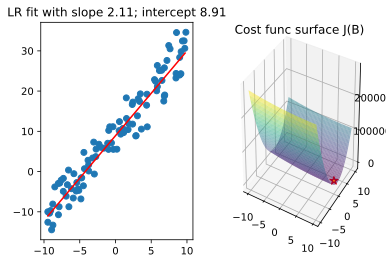

In [10]:
# data generation
x = np.random.uniform(-10, 10, 100)
noise = np.random.normal(3, 3, 100) 

# y = 2x + 7 + e
y =  2 * x + 7 + noise

# horizontally stack constant column and feature column
x = np.hstack([np.ones((x.shape[0],1)),x.reshape(-1,1)])

alpha = .0004 # learning rate
tol = .001 # tolerance level for stopping criterion
Beta = np.random.uniform(-10,10, size=2) # random starting coefficients
        
display.clear_output()
for _ in range(100): # stop after 100 iterations    
    # Animated plotting of current fit and cost surface
    viz_reg_fit_and_cost(x, y, Beta, np.linspace(-10,10,200))
    display.clear_output(wait=True)
    time.sleep(.05)
    
    # gradient descent update rule
    delta = alpha * grad_cost_function(Beta, x, y)
    Beta = Beta - delta
    
    # check stopping criterion
    if np.linalg.norm(delta) < tol:
        break  

Hopefully this helps clarify how finding the best fit line (training the linear regression model) and minimizing the cost function with GD are two sides of the same coin.

_ _ _
**Exercise** (few minutes): you're going to train your own linear regression model (i.e. find coefficients) on toy data of the form:

$$ y = 17 + 2x_1 + 5x_2 + 10x_3 + 20x_4 + \epsilon $$

In the code below, everything is set up for you except for the gradient descent update rule. Fill it in yourself and see if you can get close to the true coefficients. Refer back to the **GD update rule** and **grad_cost_function** that we defined earlier, but don't just copy/paste from the last cell!
_ _ _

In [11]:
# data generation
x = np.random.uniform(-10, 10, (100,4))
noise = np.random.normal(3, 3, 100)

# horizontally stack constant column and feature column
x = np.hstack([np.ones((x.shape[0],1)),x])

Beta_true = np.array([17, 2, 5, 10, 20])
y =  np.matmul(x, Beta_true) + noise

alpha = .00001 # learning rate
tol = .001 # tolerance level for stopping criterion
Beta_est = np.random.uniform(-10,10, size=5) # random starting coefficients
        
for _ in range(1000000): # stop after 1000000 iterations    
    
    # gradient descent update rule: 
    # YOUR CODE HERE TO REPLACE PASS
    #
    pass
        
print('Estimated Coefficients:', Beta_est)
print('True Coefficients:', Beta_true)

Estimated Coefficients: [ 8.1740075  -8.08235598  1.70332003 -5.41407134 -5.15170382]
True Coefficients: [17  2  5 10 20]


# Recap:

In this lesson, we learned:

* How to find the minimum of (convex) functions using gradient descent
* How to implement the GD algorithm in code
* How to apply the GD algorithm to train parametric machine learning models such as linear regression

# Bonus: What About Non-Convex Functions?

The function $f(x) = x^4 - 4x^3 - 2x^2 + 5x + 9$ is non-convex, and in particular has **2 local minima**. Try out the cell below a few times to see what can happen with GD! Intuitively, the descent process can get stuck in valleys that don't contain the global minimum.

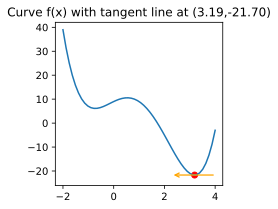

In [12]:
f = lambda x: x**4 - 4*x**3 - 2*x**2 + 5*x + 9
df_dx = lambda x: 4*x**3 - 12*x**2 - 4*x + 5

alpha = .03 # learning rate
tol = .0001 # tolerance level for stopping criterion
x = np.random.uniform(-2,4) # random starting point
        
display.clear_output()
while True:    
    # simple animated plotting
    plot_tangent_at_pt(f, df_dx, x, np.linspace(-2,4))    
    display.clear_output(wait=True)
    time.sleep(1)
    
    # gradient descent update rule
    x_delta = alpha * df_dx(x) 
    x = x - x_delta
    
    # check stopping criterion
    if np.abs(x_delta) < tol:
        break 

Luckily, the cost function for linear regression is convex and has a single global minimum. But more complex models like neural networks can give rise to cost function surfaces with massive numbers of local minima, too many to manually inspect.

How can we deal with this? There are many strategies including:

* Running GD multiple times and choosing the best result (or averaging over results)
* Modifying GD to make it less prone to getting stuck at bad critical points (adaptive and momentum-based GD, stochastic GD to add randomness)
* Using model architectures that are designed to be more robust to the local minima problem (e.g. ReLu activation units in neural networks, this is still an active area of research)